In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')

In [84]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization

In [4]:
isess = tf.InteractiveSession()

In [8]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
#reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=None)



In [131]:
rpredictions[3]

array([[[[[[ -4.66559601,   4.27477837],
           [ -5.20317364,   5.28710747],
           [ -0.6606127 ,   5.86051035],
           [ -2.45273852,   3.6417129 ],
           [ -2.01869011,   5.39894533],
           [ -3.64212418,   3.61934352]],

          [[ -3.93580985,   4.29297018],
           [ -3.43045616,   5.18210316],
           [ -3.34690046,   5.21693039],
           [ -4.1905961 ,   4.53464746],
           [ -5.50881863,   1.98260748],
           [ -2.49304748,   4.71950531]]],


         [[[ -5.7399559 ,   6.66150761],
           [ -6.32066345,   5.84404945],
           [ -2.14292359,   8.25851536],
           [ -4.27899647,   4.79582691],
           [ -6.27111578,   5.93410873],
           [ -5.59277534,   5.78494835]],

          [[ -6.90069294,   5.88878012],
           [ -5.18857479,   6.72569466],
           [ -6.23121548,   7.64384556],
           [ -6.46892881,   6.28539944],
           [ -7.40736341,   3.5209167 ],
           [ -3.24559736,   7.50503874]]],


    

In [12]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
#saver = tf.train.Saver()
svaer = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/model.ckpt-1337')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

In [163]:

# Main image processing routine.
def process_image(img, select_threshold=0.0, nms_threshold=.2, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    rpredictions[0] = rpredictions[0] * 10
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=20)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

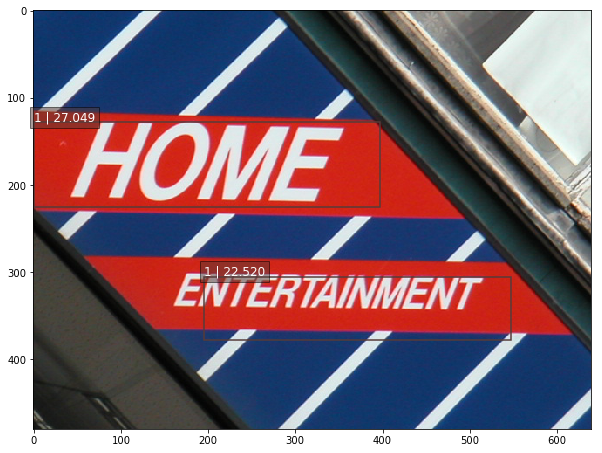

In [164]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Test-Images/img_105.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)